# Imported Libraries

In [1]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization, LSTM, Input, Reshape 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import os

# Image Dataset Import

In [2]:
labels = ['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
img_size = 224
def get_data(data_dir):
    data = [] 
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                crop_image= img_arr[0:1728,430:2190]
                resized_arr = cv2.resize(crop_image, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#function call to get_data function that takes file path of the dataset.
data= get_data('dataset/dataset_all_equal_size_image/')

<ipython-input-2-b08f5e223f84>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
data.shape

(600, 2)

In [5]:
type(data)

numpy.ndarray

# Dividing Data Ndarray into Normal, Cataract, Glaucoma and Retina diseases. 

In [6]:
normal= data[0:300]
normal.shape

(300, 2)

In [7]:
cataract=data[300:400]
cataract.shape

(100, 2)

In [8]:
glaucoma= data[400:500]
glaucoma.shape

(100, 2)

In [9]:
retina_disease= data[500:600]
retina_disease.shape

(100, 2)

In [10]:
random.seed(10)
np.random.shuffle(normal)
np.random.shuffle(cataract)   
np.random.shuffle(glaucoma)
np.random.shuffle(retina_disease)

# Performing Normalization and Resize operation 

In [11]:
def normalize(x_train,x_val,x_test): 
    
    x_train = np.array(x_train) / 255
    x_train.reshape(-1, img_size, img_size, 1)
    
    x_test= np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1)
    
    
    x_val= np.array(x_val) / 255
    x_val.reshape(-1, img_size, img_size, 1)
    
        
    return (x_train,x_val,x_test) 

# Separating the Images and Labels into Respective Variables

In [12]:
def image_label_split(train,validation,test):
    
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    for feature, label in train:
      x_train.append(feature)
      y_train.append(label)

    for feature, label in validation:
      x_val.append(feature)
      y_val.append(label)


    for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

        
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test= np.array(y_test)
    
    return (x_train,y_train,x_val,y_val,x_test,y_test)


# InceptionV3-LSTM MODEL

In [13]:
def model_build_compile(k):    
    baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
            layer.trainable = False

    x = baseModel.output

        # LSTM layer
    x = Reshape((25, 2048))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)

        # FC layer
    x = Flatten(name="flatten")(x)

        # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
        

        # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)
         
        # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=baseModel.input, outputs=output)
    opt = RMSprop(learning_rate=0.01, clipvalue=100)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    k=k+1
    print("model building and compiling for fold",k)
    
    return model

# Model prediction for Test Images and Computation of Sensitivity and Specificity

In [14]:
def test_pred(x_val,y_val,k):
    predictions = model.predict(x_val)
    predictions = np.argmax(predictions, axis = -1)
    
    print('----------------Test accuracy for',k+1,'fold----------------')
    #Confusion matrix, Accuracy, sensitivity and specificity
    cm1 = confusion_matrix(y_val,predictions)
    print('Confusion Matrix : \n', cm1)

    #####from confusion matrix calculate accuracy
    
    sensitivity_1_normal = (cm1[0,0])/(cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (cm1[1,1])/(cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (cm1[2,2])/(cm1[2,0]+cm1[2,1]+cm1[2,2]+cm1[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (cm1[3,3])/(cm1[3,0]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])/(cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[1,1]+cm1[1,2]+cm1[1,3]+cm1[2,1]+cm1[2,2]+cm1[2,3]+cm1[3,1]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])/(cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[0,0]+cm1[0,2]+cm1[0,3]+cm1[2,0]+cm1[2,2]+cm1[2,3]+cm1[3,0]+cm1[3,2]+cm1[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])/(cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[0,0]+cm1[0,1]+cm1[0,3]+cm1[1,0]+cm1[1,1]+cm1[1,3]+cm1[3,0]+cm1[3,1]+cm1[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])/(cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[0,0]+cm1[0,1]+cm1[0,2]+cm1[1,0]+cm1[1,1]+cm1[1,2]+cm1[2,0]+cm1[2,1]+cm1[2,2])
    #print('Specificity : ', specificity_4_retina_disease)
    
    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(cm1))
    test_accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)
    print('-----------------------------End of',k+1,'Fold--------------------------')
    return test_accuracy,Specificity,Sensitivity,cm1


In [15]:
CM= []
test_accuracy=[]
test_sensitivity=[]
test_specificity=[]
train_acc = []
val_acc = []
train_loss = []
val_loss = []

# InceptionV3-LSTM 5 Fold Cross Validation

In [16]:
for k in range (5):  # for loop to run 5 folds 
    n_normal=30      # specifying the number of images for normal class in test phase,calulated as per 10% of total normal class images 300.
    n_rest=10        # specifying the number of images for disease classes in test phase,calulated as per 10% of total normal class images 100.
    
    # Adding the images in normal validation set by using k*n_normal to (k+1)*n_normal as index values for normal dataset divided in cell 6.
    test_normal= normal[k*n_normal:(k+1)*n_normal]                              
    print('------------------------Start of',k+1,'Fold------------------------')
    print('test images for normal class from',k*n_normal,(k+1)*n_normal)
    
    # Adding the images in cataract validation set by using k*n_rest to (k+1)*n_rest as index values for cataract dataset divided in cell 7.
    test_cataract= cataract[k*n_rest:(k+1)*n_rest]
    print('test images for cataract class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in gluacoma validation set by using k*n_rest to (k+1)*n_rest as index values for gluacoma dataset divided in cell 8.
    test_glaucoma= glaucoma[k*n_rest:(k+1)*n_rest]
    print('test images for glaucoma class from',k*n_rest,(k+1)*n_rest)
    
    # Adding the images in retina disease validation set by using k*n_rest to (k+1)*n_rest as index values for retina disease dataset divided in cell 9.
    test_retina= retina_disease[k*n_rest:(k+1)*n_rest]
    print('test images for retina disease class from',k*n_rest,(k+1)*n_rest)
    
    # Now for train and validation set of Normal images first adding 0 to k*n_normal images and then adding all the images from (k+1)*n_normal till last image. 
    
    train_validation_normal= normal[:k*n_normal] 
    train_validation_normal= np.append(train_validation_normal,normal[(k+1)*n_normal:],axis=0)
    print('train_validation images for normal class from 0 to',k*n_normal,'and',(k+1)*n_normal,'to 300')

    # Now for train and validation set of cataract images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 

    train_validation_cataract= cataract[:k*n_rest] 
    train_validation_cataract= np.append(train_validation_cataract,cataract[(k+1)*n_rest:],axis=0)
    print('train_validation images for cataract class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of glaucoma images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_glaucoma= glaucoma[:k*n_rest] 
    train_validation_glaucoma= np.append(train_validation_glaucoma,glaucoma[(k+1)*n_rest:],axis=0)
    print('train_validation  images for glaucoma class from 0',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    # Now for train and validation set of retina disease images first adding 0 to k*n_rest images and then adding all the images from (k+1)*n_rest till last image. 
    train_validation_retina= retina_disease[:k*n_rest] 
    train_validation_retina= np.append(train_validation_retina,retina_disease[(k+1)*n_rest:],axis=0)
    print('train_validation images for retina disease class from 0 to',k*n_rest,'and',(k+1)*n_rest,'to 100')
    
    
    # Splitting the train validation datasets in 80:20 ratio which would eventually give us 70% images in train and 20% images in validation and 10% in test.
    normal_train, normal_validation                 = train_test_split(train_validation_normal, test_size=0.20, random_state=14,shuffle=True)
    cataract_train, cataract_validation             = train_test_split(train_validation_cataract, test_size=0.20, random_state=14,shuffle=True)
    glaucoma_train, glaucoma_validation             = train_test_split(train_validation_glaucoma, test_size=0.20, random_state=14,shuffle=True)
    retina_disease_train, retina_disease_validation = train_test_split(train_validation_retina, test_size=0.20, random_state=14,shuffle=True)

    # Appending all train set images for all classes
    train= np.append(normal_train,cataract_train,axis=0)
    train= np.append(train,glaucoma_train,axis=0)
    train= np.append(train,retina_disease_train,axis=0)

    # Appending all validation set images for all classes
    validation= np.append(normal_validation,cataract_validation,axis=0)
    validation= np.append(validation,glaucoma_validation,axis=0)
    validation= np.append(validation,retina_disease_validation,axis=0)
    
    # Appending all test set images for all classes
    test= np.append(test_normal,test_cataract,axis=0)
    test= np.append(test,test_glaucoma,axis=0)
    test= np.append(test,test_retina,axis=0)    
    
    # Shuffling the train validation and test set as they are added sequentially. 
    random.seed(6)
    np.random.shuffle(train)
    np.random.shuffle(validation)   
    np.random.shuffle(test)
 
    # Passing the train validation test as argument for image_label_split function that return features and labels separated.
    x_train,y_train,x_val,y_val,x_test,y_test = image_label_split(train,validation,test)
    
    # Passing the x_Train x_val and x_test as a argument for normalize function that returns the normalized and reshaped sets.
    x_train,x_val,x_test = normalize(x_train,x_val,x_test)
    
    # model building and model compile is done using a model_build_compile(). 
    
    model = model_build_compile(k)
    # passing x_train,y_train and x_val,y_val for model.fit
    history = model.fit(x_train,y_train,epochs =50, validation_data = (x_val,y_val))
    

    train_acc = np.append(train_acc,history.history['accuracy'])
    val_acc = np.append(val_acc,history.history['val_accuracy'])
    
    train_loss = np.append(train_loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
                        
    x,y,z,c = test_pred(x_test,y_test,k)
    
    CM.append([c])
    test_accuracy.append(x)
    test_specificity.append(y)
    test_sensitivity.append(z)
    

------------------------Start of 1 Fold------------------------
test images for normal class from 0 30
test images for cataract class from 0 10
test images for glaucoma class from 0 10
test images for retina disease class from 0 10
train_validation images for normal class from 0 to 0 and 30 to 300
train_validation images for cataract class from 0 to 0 and 10 to 100
train_validation  images for glaucoma class from 0 0 and 10 to 100
train_validation images for retina disease class from 0 to 0 and 10 to 100
model building and compiling for fold 1
Epoch 1/50
14/14 [==============================] - 30s 2s/step - loss: 14.8860 - accuracy: 0.4583 - val_loss: 89.6661 - val_accuracy: 0.2963
Epoch 2/50
14/14 [==============================] - 27s 2s/step - loss: 7.0474 - accuracy: 0.5417 - val_loss: 22.0998 - val_accuracy: 0.3056
Epoch 3/50
14/14 [==============================] - 28s 2s/step - loss: 7.1395 - accuracy: 0.5579 - val_loss: 10.1759 - val_accuracy: 0.3796
Epoch 4/50
14/14 [========

model building and compiling for fold 2
Epoch 1/50
14/14 [==============================] - 34s 2s/step - loss: 15.4808 - accuracy: 0.4074 - val_loss: 101.0422 - val_accuracy: 0.1944
Epoch 2/50
14/14 [==============================] - 29s 2s/step - loss: 7.2575 - accuracy: 0.5694 - val_loss: 25.8822 - val_accuracy: 0.5000
Epoch 3/50
14/14 [==============================] - 30s 2s/step - loss: 4.9677 - accuracy: 0.6319 - val_loss: 36.0923 - val_accuracy: 0.4352
Epoch 4/50
14/14 [==============================] - 30s 2s/step - loss: 5.3211 - accuracy: 0.6227 - val_loss: 16.2035 - val_accuracy: 0.3148
Epoch 5/50
14/14 [==============================] - 31s 2s/step - loss: 2.3461 - accuracy: 0.7176 - val_loss: 11.3036 - val_accuracy: 0.3704
Epoch 6/50
14/14 [==============================] - 32s 2s/step - loss: 2.1307 - accuracy: 0.7546 - val_loss: 10.7333 - val_accuracy: 0.4167
Epoch 7/50
14/14 [==============================] - 33s 2s/step - loss: 3.3924 - accuracy: 0.7477 - val_loss: 12

14/14 [==============================] - 34s 2s/step - loss: 4.9056 - accuracy: 0.6227 - val_loss: 21.2603 - val_accuracy: 0.3796
Epoch 5/50
14/14 [==============================] - 34s 2s/step - loss: 4.6078 - accuracy: 0.6481 - val_loss: 6.2023 - val_accuracy: 0.4167
Epoch 6/50
14/14 [==============================] - 34s 2s/step - loss: 1.9845 - accuracy: 0.7269 - val_loss: 21.8392 - val_accuracy: 0.2870
Epoch 7/50
14/14 [==============================] - 34s 2s/step - loss: 2.4932 - accuracy: 0.7292 - val_loss: 10.8939 - val_accuracy: 0.5741
Epoch 8/50
14/14 [==============================] - 34s 2s/step - loss: 2.0287 - accuracy: 0.7477 - val_loss: 6.9370 - val_accuracy: 0.3333
Epoch 9/50
14/14 [==============================] - 35s 3s/step - loss: 1.2005 - accuracy: 0.8287 - val_loss: 6.9803 - val_accuracy: 0.3056
Epoch 10/50
14/14 [==============================] - 35s 2s/step - loss: 0.8895 - accuracy: 0.8426 - val_loss: 5.5220 - val_accuracy: 0.2963
Epoch 11/50
14/14 [========

# Test Evaluation Results

In [17]:
test_accuracy

[0.5166666666666667, 0.6166666666666667, 0.65, 0.35, 0.6166666666666667]

In [18]:
mean_test_accuracy=np.mean(test_accuracy)
mean_test_accuracy

0.55

In [19]:
test_sensitivity

[0.39166666666666666, 0.4916666666666667, 0.575, 0.35833333333333334, 0.525]

In [20]:
mean_test_sensitivity= np.mean(test_sensitivity)
mean_test_sensitivity

0.4683333333333334

In [21]:
test_specificity

[0.7276060277483427,
 0.8059116809116809,
 0.8321581196581196,
 0.6559198024715266,
 0.8058780529755761]

In [22]:
mean_test_specificity= np.mean(test_specificity)
mean_test_specificity

0.7654947367530492

# Training and Validation Evaluation Results

In [23]:
train_acc

array([0.45833334, 0.54166669, 0.55787039, 0.6412037 , 0.6388889 ,
       0.69907409, 0.71527779, 0.76851851, 0.84027779, 0.87962961,
       0.87037039, 0.81712961, 0.9074074 , 0.93518519, 0.91435188,
       0.91666669, 0.92592591, 0.93518519, 0.94444442, 0.9675926 ,
       0.9675926 , 0.9699074 , 0.9375    , 0.93518519, 0.94444442,
       0.97685188, 0.9699074 , 0.96064812, 0.94444442, 0.9675926 ,
       0.97222221, 0.97685188, 0.94907409, 0.97685188, 0.96064812,
       0.94675928, 0.97916669, 0.97222221, 0.97685188, 0.97685188,
       0.9861111 , 0.95833331, 0.95833331, 0.98842591, 0.96064812,
       0.9675926 , 0.9837963 , 0.97685188, 0.99305558, 0.98148149,
       0.4074074 , 0.56944442, 0.63194442, 0.62268519, 0.7175926 ,
       0.75462961, 0.74768519, 0.8125    , 0.83564812, 0.87731481,
       0.7986111 , 0.88425928, 0.93055558, 0.90046299, 0.91203701,
       0.91435188, 0.91898149, 0.96064812, 0.9675926 , 0.91435188,
       0.94907409, 0.94444442, 0.94675928, 0.96064812, 0.96296

In [24]:
mean_train_accuracy=np.mean(train_acc)
mean_train_accuracy

0.8978425928354263

In [25]:
val_acc

array([0.2962963 , 0.30555555, 0.37962964, 0.25      , 0.1574074 ,
       0.33333334, 0.5925926 , 0.53703701, 0.28703704, 0.6111111 ,
       0.3425926 , 0.3611111 , 0.44444445, 0.46296296, 0.46296296,
       0.35185185, 0.52777779, 0.44444445, 0.4537037 , 0.23148148,
       0.57407409, 0.52777779, 0.4074074 , 0.5462963 , 0.64814812,
       0.62037039, 0.6574074 , 0.57407409, 0.62037039, 0.56481481,
       0.62037039, 0.52777779, 0.62037039, 0.56481481, 0.53703701,
       0.56481481, 0.5462963 , 0.5925926 , 0.48148149, 0.5925926 ,
       0.49074075, 0.62037039, 0.56481481, 0.62962961, 0.52777779,
       0.5925926 , 0.5925926 , 0.5925926 , 0.56481481, 0.6111111 ,
       0.19444445, 0.5       , 0.43518519, 0.31481481, 0.37037036,
       0.41666666, 0.3425926 , 0.2962963 , 0.39814815, 0.2962963 ,
       0.25925925, 0.5       , 0.49074075, 0.51851851, 0.5462963 ,
       0.48148149, 0.49074075, 0.51851851, 0.31481481, 0.62037039,
       0.43518519, 0.57407409, 0.53703701, 0.50925928, 0.57407

In [26]:
mean_val_accuracy=np.mean(val_acc)
mean_val_accuracy

0.49062963223457334

In [27]:
train_loss

array([1.48859978e+01, 7.04742765e+00, 7.13954687e+00, 3.26615858e+00,
       4.91187525e+00, 2.74668908e+00, 2.65329766e+00, 2.14300656e+00,
       1.38960099e+00, 1.29897487e+00, 9.35277522e-01, 1.31745064e+00,
       4.85455334e-01, 4.23509032e-01, 4.86319810e-01, 4.38042879e-01,
       4.66184169e-01, 4.90887254e-01, 6.41161740e-01, 1.74766377e-01,
       2.57000327e-01, 1.69235244e-01, 5.19961655e-01, 5.18275440e-01,
       3.80493760e-01, 1.39512450e-01, 1.93364114e-01, 3.01398695e-01,
       2.96037763e-01, 4.00338411e-01, 2.64167905e-01, 1.82599902e-01,
       2.91099817e-01, 3.07638615e-01, 2.86613107e-01, 6.00891352e-01,
       7.21284747e-02, 1.69293419e-01, 1.34037510e-01, 1.37226701e-01,
       1.26281485e-01, 5.29202282e-01, 2.73458958e-01, 1.33905783e-01,
       2.84882188e-01, 3.38376790e-01, 1.80160508e-01, 2.08130136e-01,
       7.84452334e-02, 1.41649365e-01, 1.54807987e+01, 7.25753546e+00,
       4.96772480e+00, 5.32112837e+00, 2.34611011e+00, 2.13071632e+00,
      

In [28]:
mean_train_loss=np.mean(train_loss)
mean_train_loss

1.2308800502121449

In [29]:
val_loss

array([ 89.66611481,  22.09983826,  10.17586422,  44.8885994 ,
        21.22432518,   7.66131687,   5.64215183,   3.03474164,
         8.42742729,   3.46080923,   8.02373505,   6.46243715,
         4.56035709,   4.43408298,   9.26592827,  11.20942402,
         8.16215706,  12.13919735,   8.53639889,  13.00899601,
         5.80073595,   5.3161478 ,  11.29268646,   9.1288414 ,
         8.1673317 ,   6.76663113,   7.6253562 ,   9.06472778,
         9.12248421,   7.62374163,   6.21712971,   8.99226189,
         5.95892572,  10.82538319,  22.35163498,  13.13454723,
        13.15687943,   9.37051296,   9.58472061,   7.7275548 ,
        10.06571484,  11.40365791,   7.41928101,   9.26370811,
        12.07525158,   7.61726046,   9.75984287,  11.20426083,
        10.02727032,   9.93282986, 101.04224396,  25.88222885,
        36.09226608,  16.20354462,  11.30362034,  10.73334789,
        12.22359848,  13.2954216 ,   6.71817827,  10.91052151,
        20.38394547,   6.15647221,   6.21141577,  11.91

In [30]:
mean_val_loss=np.mean(val_loss)
mean_val_loss

13.798260963439942

# Plot to Visualize the Number of Images in Each Label of Trainig Dataset

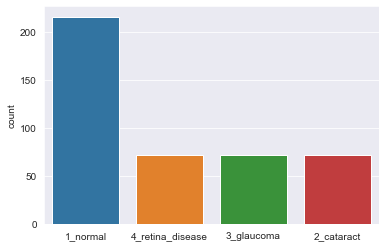

In [31]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Test Dataset.

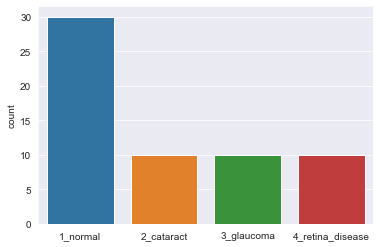

In [32]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Plot to Visualize the Number of Images in Each Label of Validation Dataset.

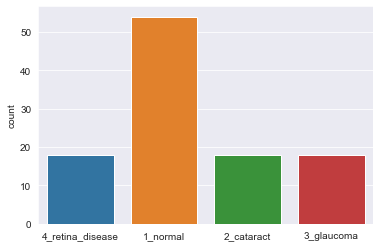

In [33]:
l = []
for i in validation:
    if(i[1] == 0):
        l.append("1_normal")
        
    elif (i[1] == 1):
        l.append("2_cataract")
        
    elif (i[1] == 2):
        l.append("3_glaucoma")
        
    else :
        l.append("4_retina_disease")
            
    
sns.set_style('darkgrid')
sns.countplot(l)

# Training,Validation Accuracy and Loss Plot for 50 Epochs

In [34]:
def plot_print(i,j):
    epochs_range = range(50)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_acc[i:j], label='Training Accuracy')
    plt.plot(epochs_range, val_acc[i:j], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_loss[i:j], label='Training Loss')
    plt.plot(epochs_range, val_loss[i:j], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

Plot for  1 cross validation accuracy and loss for Training and Validation phase


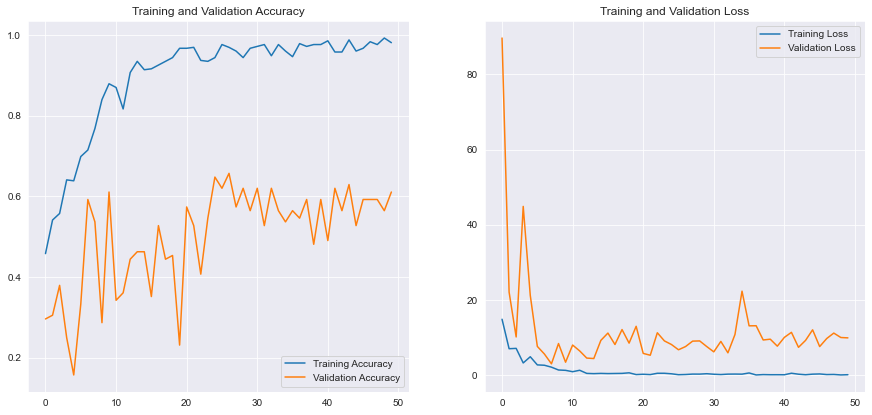

Plot for  2 cross validation accuracy and loss for Training and Validation phase


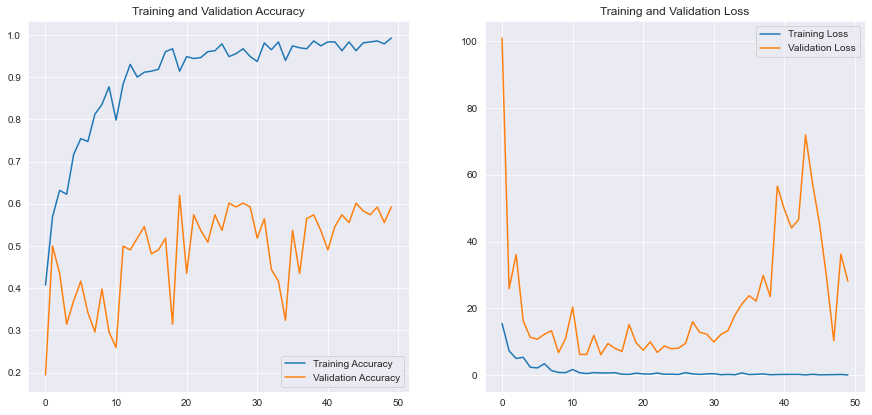

Plot for  3 cross validation accuracy and loss for Training and Validation phase


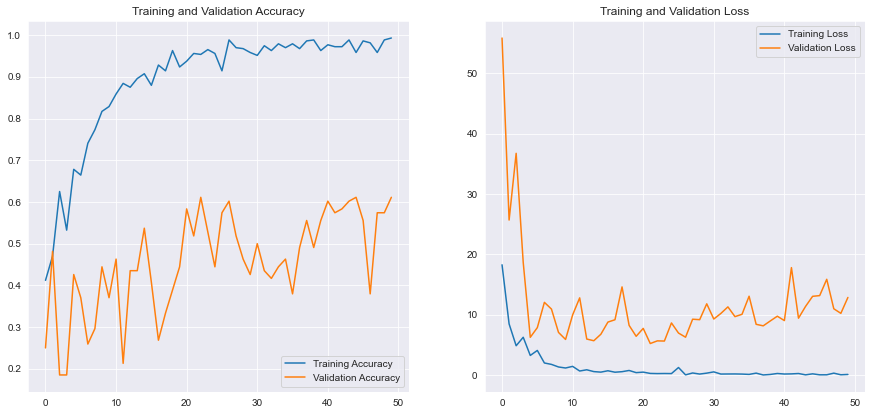

Plot for  4 cross validation accuracy and loss for Training and Validation phase


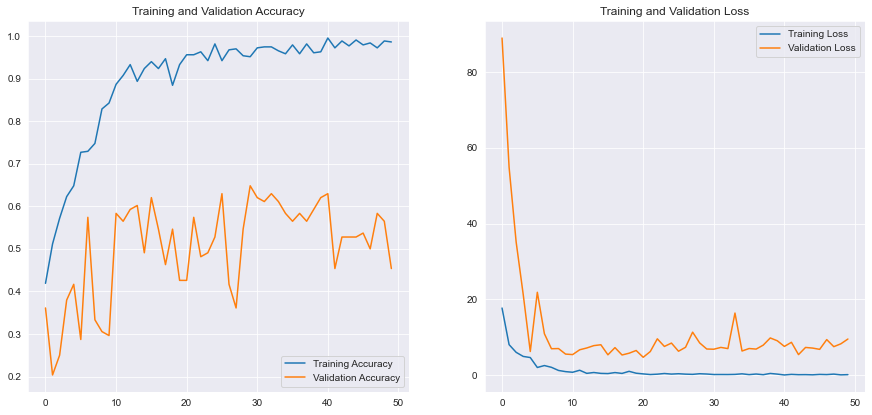

Plot for  5 cross validation accuracy and loss for Training and Validation phase


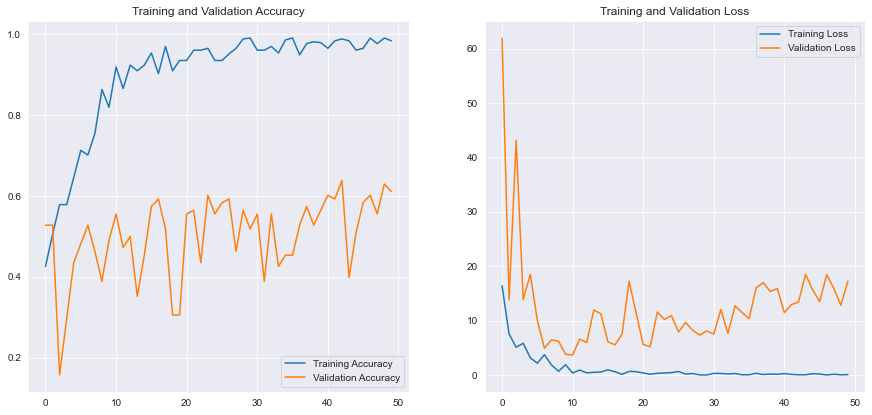

In [35]:
k=1
j=0
for i in range(0,250,50):
    j +=50
    print('Plot for ',k,'cross validation accuracy and loss for Training and Validation phase')
    k +=1
    plot_print(i,j)


# Visualizing Confusion Matrix for Each Fold

In [36]:
CM= np.array(CM)
CM.resize(5,4,4)

In [37]:
def confusionmatrix_vis(i):

        yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
        plt.figure(figsize=(8, 8))
        hm =sns.heatmap(CM[i], annot=True,annot_kws={"size": 20}, cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

        hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

        plt.ylabel("Actual", fontsize = 18)
        plt.xlabel("Predicted",fontsize = 18)
      
        return plt.show()

Confusion Matrix for  1 Cross Validation Test phase


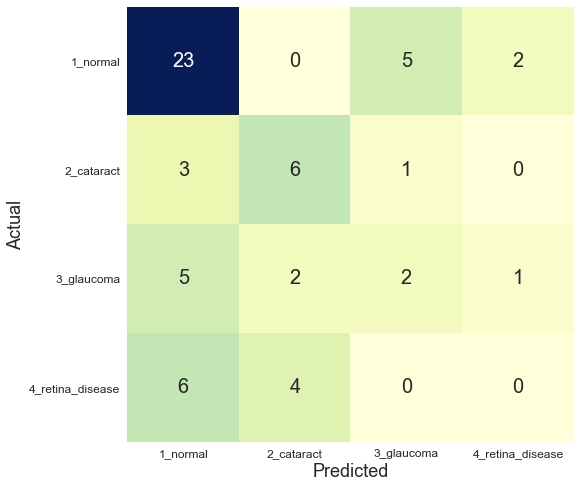

Confusion Matrix for  2 Cross Validation Test phase


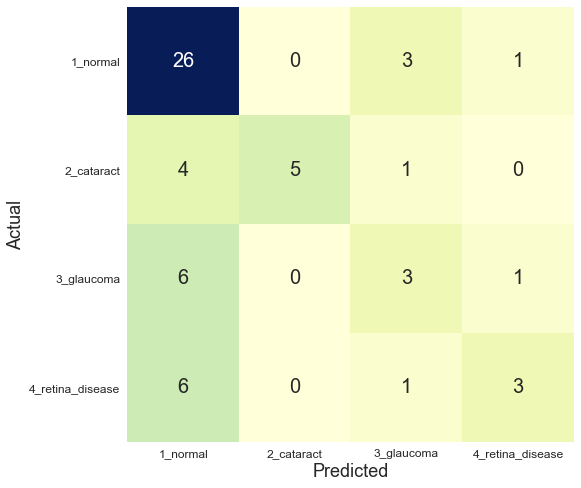

Confusion Matrix for  3 Cross Validation Test phase


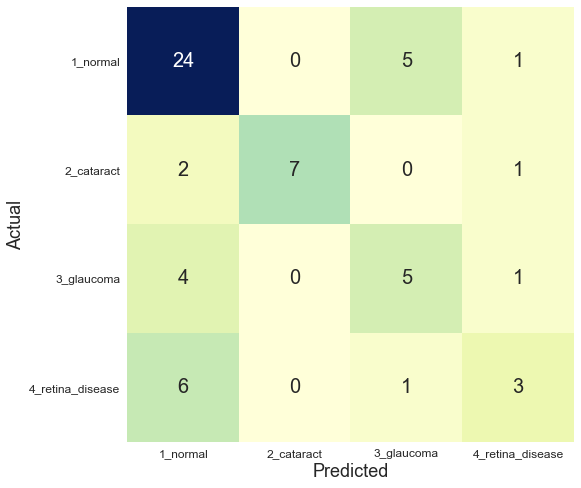

Confusion Matrix for  4 Cross Validation Test phase


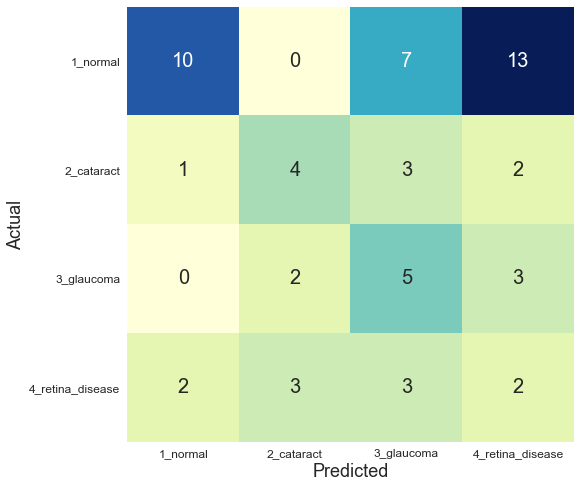

Confusion Matrix for  5 Cross Validation Test phase


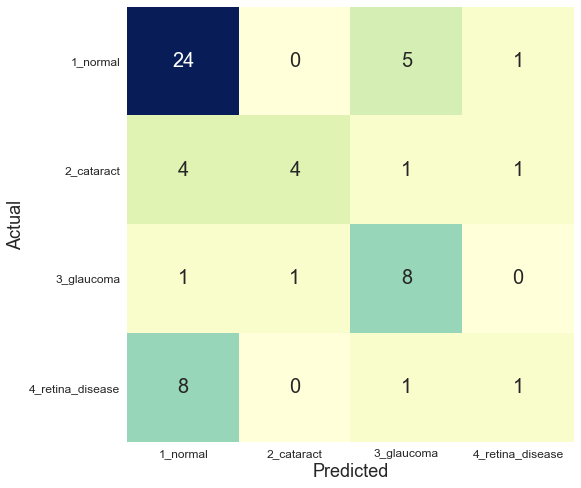

In [38]:
k=1
for i in range(5):    
    print('Confusion Matrix for ',k,'Cross Validation Test phase')
    k +=1
    confusionmatrix_vis(i)
    


# Visualizing Summarized Confusion Matrix of all 5 folds

In [39]:
CM_sum = CM[0]+CM[1]+CM[2]+CM[3]+CM[4]
CM_sum

array([[107,   0,  25,  18],
       [ 14,  26,   6,   4],
       [ 16,   5,  23,   6],
       [ 28,   7,   6,   9]], dtype=int64)

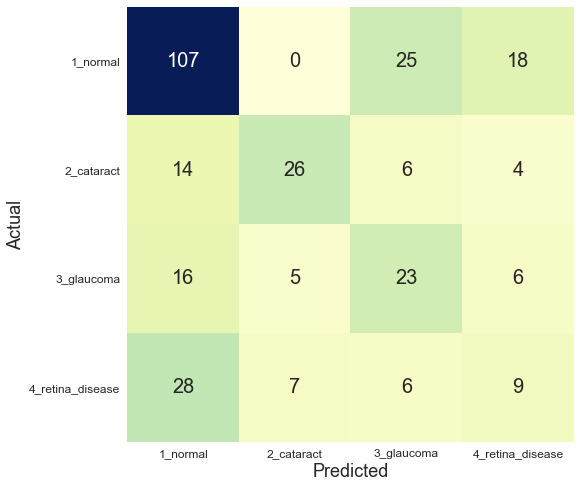

In [47]:
yticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
xticklabels=['1_normal', '2_cataract','3_glaucoma','4_retina_disease']
plt.figure(figsize=(8, 8))
hm =sns.heatmap(CM_sum, annot=True,annot_kws={"size": 20},fmt='g', cbar=False,cmap="YlGnBu",yticklabels=yticklabels,xticklabels=xticklabels)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize = 12, ) 
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 12) 

plt.ylabel("Actual", fontsize = 18)
plt.xlabel("Predicted",fontsize = 18)
      
plt.show()

# Reconfirming the values of Accuracy,Sensitivity and Specificity

In [48]:
    sensitivity_1_normal = (CM_sum[0,0])/(CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[0,3])
    #print('Sensitivity_1_normal          : ', sensitivity_1_normal )

    sensitivity_2_cataract = (CM_sum[1,1])/(CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3])
    #print('Sensitivity_2_cataract        : ', sensitivity_2_cataract )


    sensitivity_3_glaucoma = (CM_sum[2,2])/(CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3])
    #print('Sensitivity_3_glaucoma        : ', sensitivity_3_glaucoma )

    sensitivity_4_retina_disease = (CM_sum[3,3])/(CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Sensitivity_4_retina_disease  : ', sensitivity_4_retina_disease )
    
    specificity_1_normal = (CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[1,0]+CM_sum[2,0]+CM_sum[3,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[1,3]+CM_sum[2,1]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,1]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_1_normal)

    specificity_2_cataract = (CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])/(CM_sum[0,1]+CM_sum[2,1]+CM_sum[3,1]+CM_sum[0,0]+CM_sum[0,2]+CM_sum[0,3]+CM_sum[2,0]+CM_sum[2,2]+CM_sum[2,3]+CM_sum[3,0]+CM_sum[3,2]+CM_sum[3,3])
    #print('Specificity : ', specificity_2_cataract)

    specificity_3_glaucoma = (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])/(CM_sum[0,2]+CM_sum[1,2]+CM_sum[3,2]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,3]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,3]+CM_sum[3,0]+CM_sum[3,1]+CM_sum[3,3])
    #print('Specificity : ', specificity_3_glaucoma)

    specificity_4_retina_disease= (CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])/(CM_sum[0,3]+CM_sum[1,3]+CM_sum[2,3]+CM_sum[0,0]+CM_sum[0,1]+CM_sum[0,2]+CM_sum[1,0]+CM_sum[1,1]+CM_sum[1,2]+CM_sum[2,0]+CM_sum[2,1]+CM_sum[2,2])
    #print('Specificity : ', specificity_4_retina_disease)

    Sensitivity= (sensitivity_1_normal + sensitivity_2_cataract + sensitivity_3_glaucoma + sensitivity_4_retina_disease)/4
    #print(Sensitivity)
    
    Specificity= (specificity_1_normal + specificity_2_cataract + specificity_3_glaucoma + specificity_4_retina_disease)/4
    #print(Specificity)
    
    total1=sum(sum(CM_sum))
    test_accuracy=(CM_sum[0,0]+CM_sum[1,1]+CM_sum[2,2]+CM_sum[3,3])/total1
    
    print ('Accuracy    : ', test_accuracy)
    print ('Specificity : ', Specificity)
    print ('Sensitivity : ', Sensitivity)

    

Accuracy    :  0.55
Specificity :  0.765412994416625
Sensitivity :  0.4683333333333333


# Model Summary

In [45]:
model_build_compile(k)

model building and compiling for fold 7


In [46]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_388 (BatchN (None, 111, 111, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 111, 111, 32) 0           batch_normalization_388[0][0]    
____________________________________________________________________________________________